In [30]:
%load_ext autoreload
%autoreload 2

import numpy as numpy
import torch
import matplotlib.pyplot as plt

from cre_reg.optimization import optimize_weights
from cre_reg.negative_log_likelihood import eval_naive_log_Pij, evaluate_nll
from cre_reg.regularization import entropy_regularization, anchor_regularization, tikhonov_regularization, smootness_regularization
from cre_reg.experiments.two_gaussian_mixture import TwoGaussianModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate the Data

In [31]:
# Parameters for the dataset
n_images = 100000
num_structures = 41
noise_stdev = 0.5
num_epochs = 100

In [32]:
# Generate the images
tgm = TwoGaussianModel()
noiseless_images = tgm.sample(n_images).to(device)
images = noiseless_images + noise_stdev * torch.randn_like(noiseless_images)


Plot the data to see the effect of the noise.

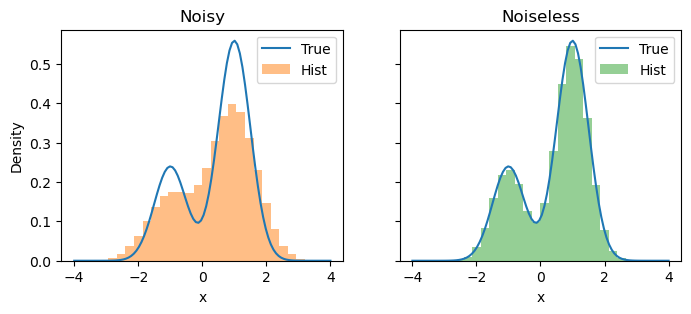

In [33]:

# Functional form of the Boltzmann Density for Reference.
xax = torch.linspace(-4, 4, 100)
pi = tgm.evaluate_boltzmann(xax)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
nbins = 30
for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')

axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')
axes[1].hist(noiseless_images.cpu().numpy(), bins=nbins, range=(-4, 4), 
             color="C2", density=True, alpha=0.5, label='Hist')

for ax in axes:
    ax.set_xlabel('x')
    ax.legend()
axes[0].set_title('Noisy')
axes[1].set_title('Noiseless')
axes[0].set_ylabel('Density')
plt.show()


# Perform the Reweighting

Construct the structures and evaluate the log-likelihood pairs.

In [34]:
# Evently spaced clusters:
x = torch.linspace(-4, 4, num_structures, device=device)
negative_log_weights = torch.randn_like(x) * 0.01 # Random initial weights
cluster_sizes = torch.ones_like(negative_log_weights)

distance_matrix = (images.unsqueeze(1) - x.unsqueeze(0))**2
log_Pij = eval_naive_log_Pij(distance_matrix, noise_stdev)
print(log_Pij.shape)

torch.Size([100000, 41])


## Perform the optimization with no nontrivial regularization.

In [35]:
loss_fxn = lambda negative_log_weights: evaluate_nll(negative_log_weights, log_Pij)
# Anchors the average log weight to be zero to keep it drifting off to inf, -inf
regularization_fxn = anchor_regularization 

optimized_negative_log_weight_no_reg, losses_no_reg = optimize_weights(
    log_Pij, loss_fxn, log_weights_init=negative_log_weights, 
    cluster_sizes=cluster_sizes, regularization_fxn=regularization_fxn,
    num_epochs=num_epochs,
    )


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 119.12it/s]


Text(0.5, 1.0, 'Loss (No Regularization)')

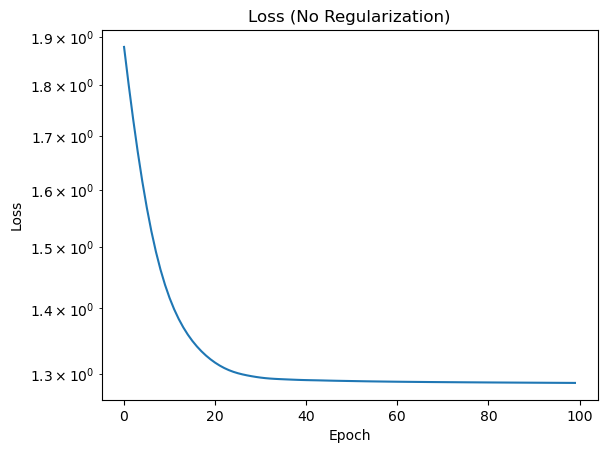

In [36]:
fig = plt.figure()
plt.semilogy(losses_no_reg.numpy())
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss (No Regularization)")

In [37]:
optimized_boltzmann = torch.exp(-optimized_negative_log_weight_no_reg)
optimized_boltzmann /= optimized_boltzmann.sum() * (x[1] - x[0]) 

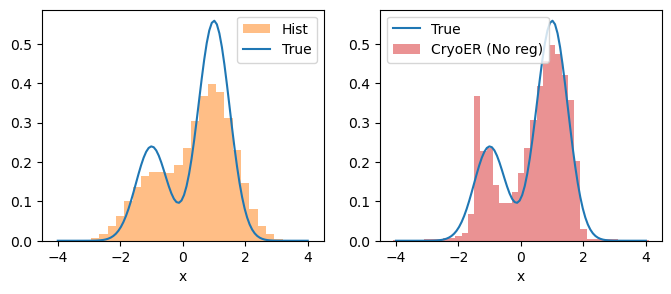

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

dx = (x[1] - x[0]).cpu().numpy()


axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')

axes[1].bar(x.cpu(), optimized_boltzmann.detach().cpu().numpy(), 
    width=dx, label='CryoER (No reg)', color="C3", alpha=0.5)
# axes[1].plot(x.cpu(), optimized_boltzmann.detach().cpu().numpy(), label='CryoER (No reg)', color="C3")

for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')
    ax.set_xlabel('x')
    ax.legend()
plt.legend()
# print(optimized_log_weight_no_reg)

## Apply some entropic regularization

In [39]:
smooth_reg_strength = 0.00008
entr_reg_strength = 0.000

def new_regularization_fxn(negative_log_weights):
    s_reg_loss = smootness_regularization(negative_log_weights) * smooth_reg_strength
    e_reg_loss = entropy_regularization(negative_log_weights) * entr_reg_strength
    return s_reg_loss + e_reg_loss

optimized_negative_log_weight_entropy_reg, losses_reg = optimize_weights(
    log_Pij, loss_fxn, cluster_sizes=cluster_sizes, regularization_fxn=new_regularization_fxn,
    num_epochs=num_epochs,
    )

optimized_boltzmann_w_reg = torch.exp(-optimized_negative_log_weight_entropy_reg)
optimized_boltzmann_w_reg /= optimized_boltzmann_w_reg.sum() * (x[1] - x[0])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 127.79it/s]


Text(0.5, 1.0, 'Loss (W. Regularization)')

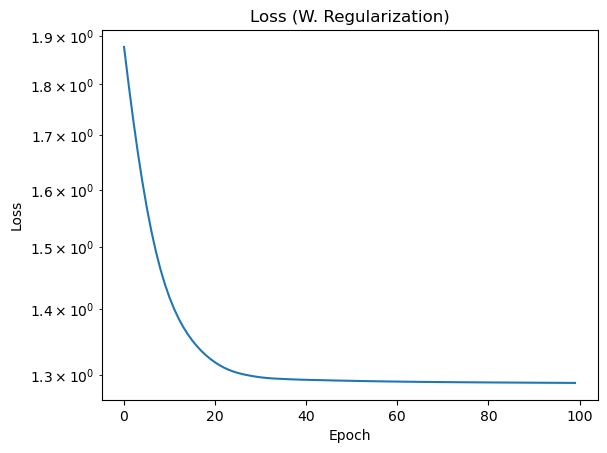

In [40]:
fig = plt.figure()
plt.semilogy(losses_reg.numpy())
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss (W. Regularization)")

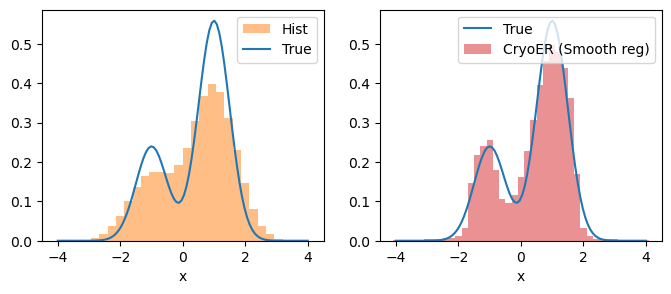

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

dx = (x[1] - x[0]).cpu().numpy()


axes[0].hist(images.cpu().numpy(), bins=nbins, range=(-4, 4), density=True, 
             alpha=0.5, color="C1", label='Hist')

axes[1].bar(x.cpu(), optimized_boltzmann_w_reg.detach().cpu().numpy(), 
    width=dx, label='CryoER (Smooth reg)', color="C3", alpha=0.5)

for ax in axes:
    ax.plot(xax, pi, label='True', c='C0')
    ax.set_xlabel('x')
    ax.legend()
plt.legend()
# print(optimized_log_weight_no_reg)

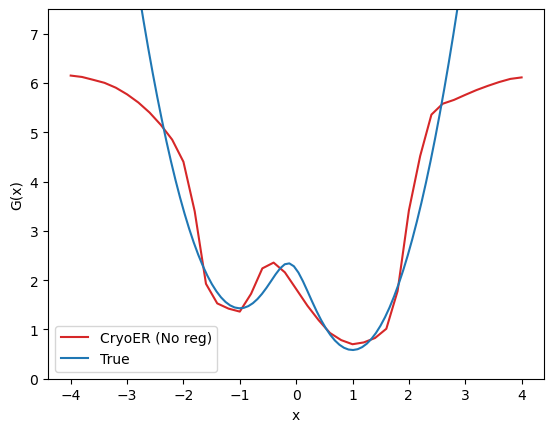

In [42]:
plt.plot(x.cpu(), -numpy.log(optimized_boltzmann_w_reg.detach().cpu().numpy()), label='CryoER (No reg)', color="C3")
plt.plot(xax, -numpy.log(pi), label='True', c='C0')
plt.ylim(0, 7.5)
plt.ylabel("G(x)")
plt.xlabel("x")
plt.legend()